In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PCA

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-7-8b5419e818f2>:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


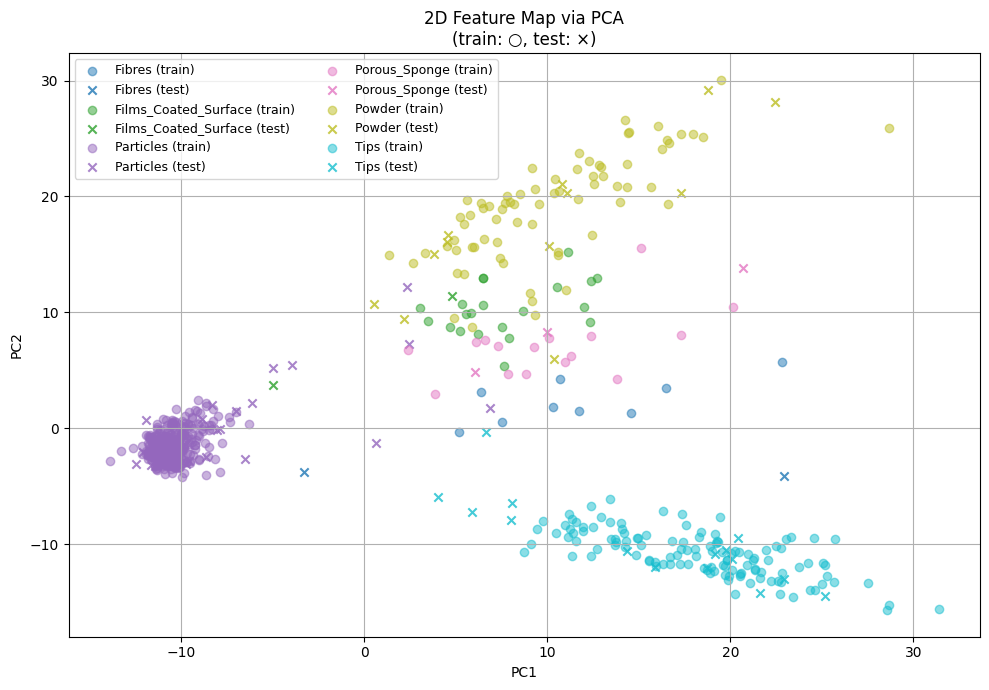

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset, random_split

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# === Feature extractor (ResNet18: take output before fc) ===
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = nn.Sequential(*list(backbone.children())[:-1])  # all but last layer

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)  # flatten output to (batch_size, feature_dim)


# === Config ===
data_dir = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/data/processed'
model_path = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/outputs/20250430_024232_lr0.0001_bs32/model.pth'
output_dir = '/content/outputs/20250430_024232_lr0.0001_bs32/misclassified_images'
subset_ratio = 0.1
batch_size = 32
input_size = (224, 224)
random_seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transform ===
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# === Load full dataset ===
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

# === Apply subset ratio (e.g., 10%) ===
subset_size = int(len(full_dataset) * subset_ratio)
subset, _ = random_split(
    full_dataset,
    [subset_size, len(full_dataset) - subset_size],
    generator=torch.Generator().manual_seed(random_seed)
)

# === Split into train/val/test (8:1:1) ===
train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))
test_size = len(subset) - train_size - val_size

train_set, _, test_set = random_split(
    subset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# === Load model and wrap it ===
backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Linear(backbone.fc.in_features, len(class_names))
backbone.load_state_dict(torch.load(model_path, map_location=device))
backbone = backbone.to(device)
backbone.eval()

model = FeatureExtractor(backbone).to(device)

# === Extract features for test set ===
features = []
labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        feats = model(inputs)
        features.append(feats.cpu().numpy())
        labels.extend(targets.numpy())

features = np.concatenate(features)
labels = np.array(labels)

# === Project to 2D with PCA ===
pca = PCA(n_components=2)
proj = pca.fit_transform(features)

# === Extract features for both train and test ===
def extract_features(dataloader):
    feats, lbls = [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            feats.append(outputs.cpu().numpy())
            lbls.extend(targets.numpy())
    return np.concatenate(feats), np.array(lbls)

train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# === Run PCA on combined features ===
all_features = np.vstack([train_features, test_features])
pca = PCA(n_components=2)
all_proj = pca.fit_transform(all_features)

train_proj = all_proj[:len(train_features)]
test_proj = all_proj[len(train_features):]

# === Color palette (1 per class) ===
colors = plt.cm.get_cmap('tab10', len(class_names))

# === Plot ===
plt.figure(figsize=(10, 7))
for class_idx, class_name in enumerate(class_names):
    # filter for each class
    train_inds = train_labels == class_idx
    test_inds = test_labels == class_idx

    plt.scatter(train_proj[train_inds, 0], train_proj[train_inds, 1],
                marker='o', color=colors(class_idx),
                label=f"{class_name} (train)", alpha=0.5)

    plt.scatter(test_proj[test_inds, 0], test_proj[test_inds, 1],
                marker='x', color=colors(class_idx),
                label=f"{class_name} (test)", alpha=0.8)

plt.title("2D Feature Map via PCA\n(train: ○, test: ×)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

## t-SNE

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-8-48e6c534331f>:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


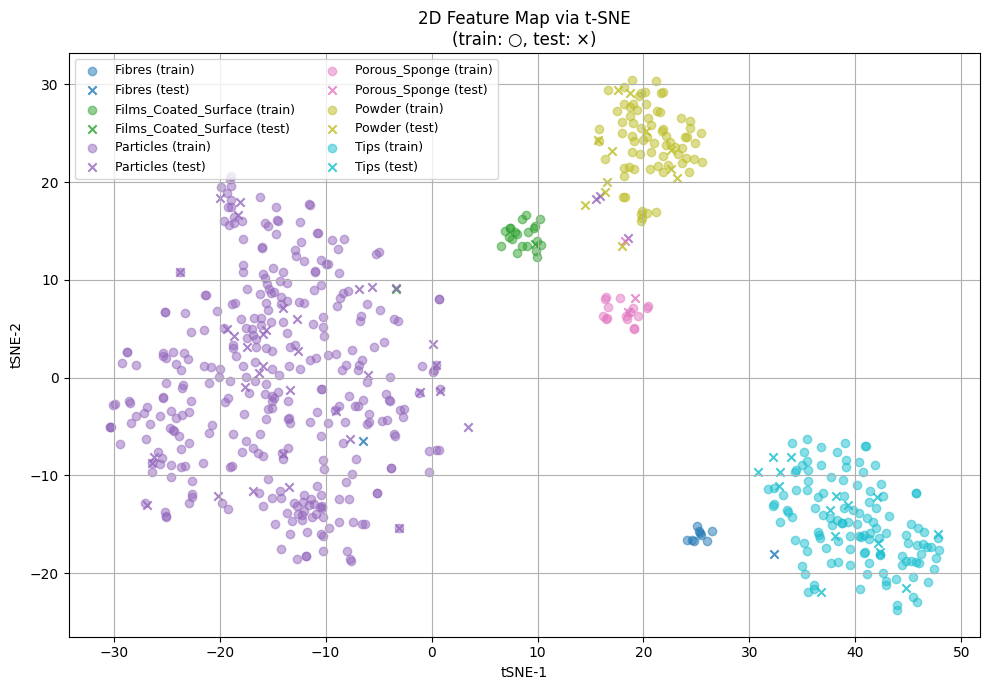

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset, random_split

# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


# === Feature extractor (ResNet18: take output before fc) ===
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.features = nn.Sequential(*list(backbone.children())[:-1])  # all but last layer

    def forward(self, x):
        x = self.features(x)
        return torch.flatten(x, 1)  # flatten output to (batch_size, feature_dim)


# === Config ===
data_dir = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/data/processed'
model_path = '/content/drive/MyDrive/Colab Notebooks/NFFA-SEM/outputs/20250430_024232_lr0.0001_bs32/model.pth'
output_dir = '/content/outputs/20250430_024232_lr0.0001_bs32/misclassified_images'
subset_ratio = 0.1
batch_size = 32
input_size = (224, 224)
random_seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transform ===
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# === Load full dataset ===
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

# === Apply subset ratio (e.g., 10%) ===
subset_size = int(len(full_dataset) * subset_ratio)
subset, _ = random_split(
    full_dataset,
    [subset_size, len(full_dataset) - subset_size],
    generator=torch.Generator().manual_seed(random_seed)
)

# === Split into train/val/test (8:1:1) ===
train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))
test_size = len(subset) - train_size - val_size

train_set, _, test_set = random_split(
    subset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(random_seed)
)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# === Load model and wrap it ===
backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Linear(backbone.fc.in_features, len(class_names))
backbone.load_state_dict(torch.load(model_path, map_location=device))
backbone = backbone.to(device)
backbone.eval()

model = FeatureExtractor(backbone).to(device)

# === Extract features for test set ===
features = []
labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        feats = model(inputs)
        features.append(feats.cpu().numpy())
        labels.extend(targets.numpy())

features = np.concatenate(features)
labels = np.array(labels)

# === Project to 2D with PCA ===
pca = PCA(n_components=2)
proj = pca.fit_transform(features)

train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)


# === Combine features ===
all_features = np.vstack([train_features, test_features])

# === t-SNE projection (slower than PCA) ===
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=30)
all_proj = tsne.fit_transform(all_features)

# === Split back into train/test ===
train_proj = all_proj[:len(train_features)]
test_proj = all_proj[len(train_features):]

# === Color map for class consistency ===
colors = plt.cm.get_cmap('tab10', len(class_names))

# === Plot ===
plt.figure(figsize=(10, 7))
for class_idx, class_name in enumerate(class_names):
    train_mask = train_labels == class_idx
    test_mask = test_labels == class_idx

    plt.scatter(train_proj[train_mask, 0], train_proj[train_mask, 1],
                marker='o', color=colors(class_idx), label=f"{class_name} (train)", alpha=0.5)

    plt.scatter(test_proj[test_mask, 0], test_proj[test_mask, 1],
                marker='x', color=colors(class_idx), label=f"{class_name} (test)", alpha=0.8)

plt.title("2D Feature Map via t-SNE\n(train: ○, test: ×)")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from torchvision.models import resnet18
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_activation(model, layer_name, input_tensor):
    activation = {}

    def hook_fn(module, input, output):
        activation[layer_name] = output.detach().cpu()

    hook = getattr(model, layer_name).register_forward_hook(hook_fn)
    model.eval()
    with torch.no_grad():
        model(input_tensor.unsqueeze(0))

    act = activation[layer_name][0]  # shape: [C, H, W]
    grid = make_grid(act.unsqueeze(1), nrow=8, normalize=True, padding=1)
    plt.figure(figsize=(10, 10))
    plt.title(f"{layer_name} Activations")
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

    hook.remove()

input_tensor = your_transformed_image  # 1 image
model = resnet18(pretrained=True)
show_activation(model, 'layer1', input_tensor)